In [1]:
import os
os.chdir("..")


In [2]:

from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import (accuracy_score, classification_report,
                             cohen_kappa_score, confusion_matrix, f1_score,
                             precision_score, balanced_accuracy_score)
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from skin_lesion_cad.features.texture import get_glcm, glcm_features, lbph
from skin_lesion_cad.features.colour import (ColorFeaturesDescriptor,
                                             ColorFeaturesExtractor)
from skin_lesion_cad.data.BOVW import (BagofWords, ColorDescriptor,
                                       DenseDescriptor, DescriptorsTransformer,
                                       LBPDescriptor)
import seaborn as sns
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from typing import Counter
from pathlib import Path
from multiprocessing.dummy import Pool
import random


In [5]:
merged_df_train = pd.read_pickle('merged_df_train.pkl')
merged_df_val = pd.read_pickle('merged_df_val.pkl')
merged_df_test = pd.read_pickle('merged_df_test.pkl')


In [8]:
X_train = merged_df_train.drop(columns=['class'])
X_test = merged_df_val.drop(columns=['class'])
y_train = merged_df_train['class']
y_test = merged_df_val['class']

scaler = DescriptorsTransformer(None)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape, X_test.shape)
svc = SVC(kernel='rbf', C=1, random_state=42,
          probability=False, class_weight='balanced')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
y_pred_train = svc.predict(X_train)

print(confusion_matrix(merged_df_val['class'], y_pred))
print('Balanced accuracy', balanced_accuracy_score(
    merged_df_train['class'], y_pred_train))
print('Balanced accuracy', balanced_accuracy_score(
    merged_df_val['class'], y_pred))
print('Train kappa', cohen_kappa_score(merged_df_train['class'], y_pred_train))
print('Validation kappa', cohen_kappa_score(merged_df_val['class'], y_pred))


(5082, 442) (1270, 442)
[[398  40  60]
 [ 77 555  46]
 [ 20  10  64]]
Balanced accuracy 0.8876778108255493
Balanced accuracy 0.7662106405916139
Train kappa 0.7784174887982479
Validation kappa 0.6582608325711004


In [10]:
from sklearn.decomposition import PCA

X_train = merged_df_train.drop(columns=['class'])
X_test = merged_df_val.drop(columns=['class'])


y_train = merged_df_train['class']
y_test = merged_df_val['class']

scaler = DescriptorsTransformer(None)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=150)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


print(X_train_pca.shape, X_test_pca.shape)

svc.fit(X_train_pca, y_train)
y_pred = svc.predict(X_test_pca)
y_pred_train = svc.predict(X_train_pca)

print(confusion_matrix(merged_df_val['class'], y_pred))
print('Balanced accuracy', balanced_accuracy_score(
    merged_df_train['class'], y_pred_train))
print('Balanced accuracy', balanced_accuracy_score(
    merged_df_val['class'], y_pred))
print('Train kappa', cohen_kappa_score(merged_df_train['class'], y_pred_train))
print('Validation kappa', cohen_kappa_score(merged_df_val['class'], y_pred))


(5082, 150) (1270, 150)
[[396  40  62]
 [ 77 550  51]
 [ 22   9  63]]
Balanced accuracy 0.8801970672767526
Balanced accuracy 0.7588676427923456
Train kappa 0.7639367559282819
Validation kappa 0.6487638334936909


In [11]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import SMOTE, ADASYN


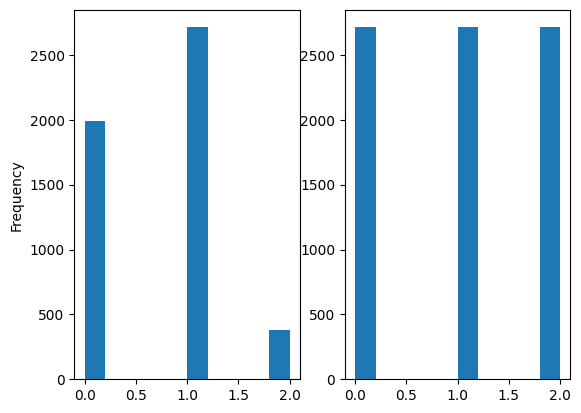

In [12]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
plt.subplot(1, 2, 1)
merged_df_train['class'].plot.hist()
# plt.show()
plt.subplot(1, 2, 2)
plt.hist(y_res)
plt.show()


In [13]:
X_train = merged_df_train.drop(columns=['class'])
X_test = merged_df_val.drop(columns=['class'])


y_train = merged_df_train['class']
y_test = merged_df_val['class']

scaler = DescriptorsTransformer(None)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply SMOTE
sm = SMOTE(random_state=42, k_neighbors=5, n_jobs=-
           1, sampling_strategy='not majority')
X_train, y_train = sm.fit_resample(X_train, y_train)


print(X_train.shape, X_test.shape)

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
y_pred_train = svc.predict(X_train)

print(confusion_matrix(merged_df_val['class'], y_pred))
print('Balanced train accuracy', balanced_accuracy_score(y_train, y_pred_train))
print('Balanced accuracy', balanced_accuracy_score(
    merged_df_val['class'], y_pred))
print('Train kappa', cohen_kappa_score(y_train, y_pred_train))
print('Validation kappa', cohen_kappa_score(merged_df_val['class'], y_pred))


(8139, 442) (1270, 442)
[[408  41  49]
 [ 66 581  31]
 [ 23  10  61]]
Balanced train accuracy 0.9341442437645903
Balanced accuracy 0.7750484773462771
Train kappa 0.9012163656468853
Validation kappa 0.6975025009635747
